In [1]:
import numpy as np
from sklearn.datasets import make_blobs

zeros = [0] * 98

def make_asymmetric_blobs (x_dist, y_dist,std, samples, dims):
    X, y = make_blobs(n_samples=samples,
                      n_features=dims, centers=[[-x_dist/2,0]+zeros, [x_dist/2,0]+zeros,
                      [0,y_dist]+zeros], cluster_std=std, shuffle=True, random_state=100)
    plt.scatter(X[y==0][:,0], X[y==0][:,1])
    plt.scatter(X[y==1][:,0], X[y==1][:,1])
    plt.scatter(X[y==2][:,0], X[y==2][:,1])
    plt.axis('equal')
    plt.grid('true')
    plt.show()
    
    return X, y





In [9]:
def get_dendrogram_weights(x, method = 'ward'):
    ytdist = distance.pdist(x, metric = 'euclidean')
    Z = hierarchy.linkage(ytdist, method)
    dn = hierarchy.dendrogram(Z)

    icoord = scipy.array(dn['icoord'])
    dcoord = scipy.array(dn['dcoord'])
    x = sorted(list(zip(dn['dcoord'])), key = lambda x: x[0][1], reverse = True)
#    print((x))
    height = x[0][0][1]
    weights = []
    x.append(([0,0,0,0],))
    while len(x) > 1:
#        print(x[0])
        weights.append(x[0][0][1] - x[1][0][1])
        x.pop(0)
#        print(len(x))
    weights = weights / height
    return weights

In [4]:
def make_5_asymmetric_blobs (one_dist, two_dist, three_dist,std, samples, dims):
    X, y = make_blobs(n_samples=samples,
                      n_features=dims, centers=[[-one_dist/2,0]+zeros, [one_dist/2,0]+zeros,
                      [0,np.sqrt(one_dist**2-(one_dist/2)**2)]+zeros, [-two_dist/2, three_dist]+zeros,
                      [two_dist/2, three_dist] +zeros],
#                       [two_dist/2, three_dist + np.sqrt(two_dist**2-(two_dist/2)**2)] + zeros],
                      cluster_std=std, shuffle=True, random_state=100)
    plt.scatter(X[y==0][:,0], X[y==0][:,1])
    plt.scatter(X[y==1][:,0], X[y==1][:,1])
    plt.scatter(X[y==2][:,0], X[y==2][:,1])
    plt.scatter(X[y==3][:,0], X[y==3][:,1])
    plt.scatter(X[y==4][:,0], X[y==4][:,1])
    plt.axis('equal')
    plt.grid('true')
    plt.show()
    return X, y
    

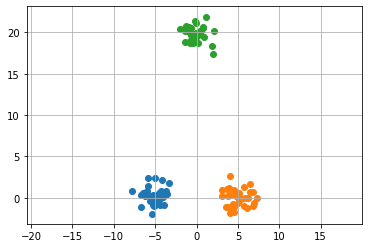

dumping pvals and partitions
Preprocessing done...




/home/mstrals/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
/home/mstrals/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead


Iteration 10: error is 225.821341
Iteration 20: error is 179.868769
Iteration 30: error is 169.927404
Iteration 40: error is 164.747038
Iteration 50: error is 160.939349
Iteration 60: error is 158.012838
Iteration 70: error is 155.694472
Iteration 80: error is 153.768385
Iteration 90: error is 152.013941
Iteration 100: error is 150.309206
Iteration 110: error is 148.769235
Iteration 120: error is 147.466366
Iteration 130: error is 146.380701
Iteration 140: error is 145.470560
Iteration 150: error is 144.690740
Iteration 160: error is 144.005293
Iteration 170: error is 143.390057
Iteration 180: error is 142.829254
Iteration 190: error is 142.312216
Iteration 200: error is 141.831353
Iteration 210: error is 141.381035
Iteration 220: error is 140.957030
Iteration 230: error is 140.556267
Iteration 240: error is 140.176741
Iteration 250: error is 139.817356
Iteration 260: error is 139.477554
Iteration 270: error is 139.156841
Iteration 280: error is 138.854511
Iteration 290: error is 138.5

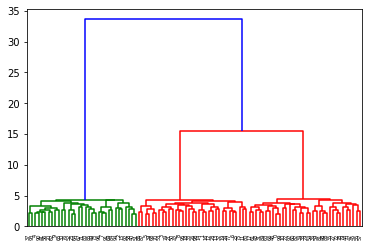

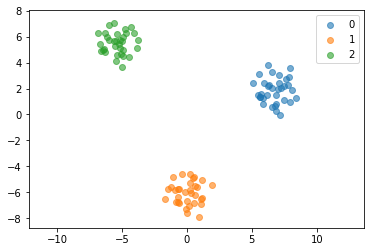

In [3]:
import math
import numpy as np
import pandas as pd
from sklearn import datasets, decomposition, metrics
from matplotlib import pyplot as plt
from hierarchy import dist, merge, calc_partitions, calc_dists
import scipy
from scipy.cluster import hierarchy
from scipy.spatial import distance
import copy
import pickle
############# CONSTANTS ##############

DATA_SIZE = 100
ITERATIONS = 700

######################################


############## METHODS ###############

def perplex_helper(Di, sigma):
    Pi = np.exp(-1*Di.copy() * sigma)
    Psum = np.sum(Pi)
    perp_calc = np.log(Psum) + sigma * np.sum(Di * Pi) / Psum
    Pf = Pi/Psum
    return Pf, perp_calc


def calc_p_vals(X, tol = 1e-5, perplexity = 30.0):
    (n, d) = X.shape

    partitions, pdist = calc_partitions(X, dist)
    P = [np.zeros((n, n)) for p in partitions]
    sigmas = [np.ones((n,1)) for p in partitions]

    for p in range(len(partitions)):
        for i in range(n):
            scaled_perplexity = perplexity*math.sqrt((n/DATA_SIZE)) #Adjust perplexity based on partiton data size
            pdists = pdist[p]
            Di = pdists[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
            Pf, perp_calc = perplex_helper(Di, sigmas[p][i])
            #perplexity calculation - binary search for best param
            min_ = -np.inf
            max_ = np.inf
            count = 0
            diff = perp_calc - np.log(scaled_perplexity)
            while diff > tol and count < 50:
                if diff > 0:
                    min_ = sigmas[p][i].copy()
                    if max_ == np.inf or max_ == -np.inf:
                        sigmas[p][i] = sigmas[p][i] * 2.
                    else:
                        sigmas[p][i] = (sigmas[p][i] + max_) / 2.
                else:
                    max_ = sigmas[p][i].copy()
                    if min_ == np.inf or min_ == -np.inf:
                        sigmas[p][i] = sigmas[p][i] / 2.
                    else:
                        sigmas[p][i] = (sigmas[p][i] + min_) / 2.
                count+=1
                Pf, perp_calc = perplex_helper(Di, sigmas[p][i])
                diff = perp_calc - np.log(scaled_perplexity)

            P[p][i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = Pf
    return P, partitions

#takes in high-dimensional data, outputs lengths of branch segments
#Outputs weights as % of total height, ordered from first cluster merge to last cluster merge
def get_dendrogram_weights(x, method = 'ward'):
    ytdist = distance.pdist(x, metric = 'euclidean')
    Z = hierarchy.linkage(ytdist, method)
    dn = hierarchy.dendrogram(Z)

    icoord = scipy.array(dn['icoord'])
    dcoord = scipy.array(dn['dcoord'])
    x = sorted(list(zip(dn['dcoord'])), key = lambda x: x[0][1], reverse = True)
#    print((x))
    height = x[0][0][1]
    weights = []
    x.append(([0,0,0,0],))
    while len(x) > 1:
#        print(x[0])
        weights.append(x[0][0][1] - x[1][0][1])
        x.pop(0)
#        print(len(x))
    weights = weights / height
    return weights

######################################################

###################### MAIN #########################


desired_classes = [0,1,2]
random_state = 1000
x_init, labels = make_asymmetric_blobs (10, 20,1, 100, 100)

np.random.seed(random_state)

#desired_classes = [0,1,2,3,4]
#x_init, labels = datasets.make_blobs(n_samples=DATA_SIZE,n_features=100, centers=5, cluster_std = 1)
y = np.random.rand(DATA_SIZE, 2)

#PCA and normalize into ball of radius 1
x = decomposition.PCA(n_components=30).fit_transform(x_init)
x = x/np.var(np.linalg.norm(x, axis=1))

(n,d) = x.shape

pvals, partitions = calc_p_vals(x)
for idx in range(len(pvals)):
    pvals[idx] = pvals[idx] + pvals[idx].T       # calculate symmetric pvals
    pvals[idx] = pvals[idx] / np.sum(pvals[idx])

    #early exaggeration
    pvals[idx] = pvals[idx] * 4.
    pvals[idx] = np.maximum(pvals[idx], 1e-12)

print("dumping pvals and partitions")

#     with open('pvals1000', 'wb') as f:
#         pickle.dump(pvals, f)
#     with open('partition1000', 'wb') as f:
#         pickle.dump(partitions, f)
#gradient descent params
#   weights = [1]+[1/len(partitions) for x in range(len(partitions)-1)]
weights = get_dendrogram_weights(x)[::-1]
weights = np.zeros(len(weights))
weights[0] = 1
#     with open('weights1000', 'wb') as f:
#         pickle.dump(weights, f)

dys = [np.zeros((n,2)) for x in range(len(partitions))]
lr = 50

# params for van der maaten's momentum magic!
prev_y = np.zeros((n,2))
init_momentum = 0.5
st_momentum = 0.8
gains = np.ones((n, 2))
min_gain = 0.01
eta = 500

print('Preprocessing done...\n\n')

for iter in range(ITERATIONS):

    #compute qvals for each partition
    qdist_temp = calc_dists(y, [partitions[0]], dist)[0]
    qdists = [qdist_temp for p in partitions]
    qvals = []
    for d in qdists:
        num = 1. / (1. + d)
        num[range(n), range(n)] = 0.
        qval = num / np.sum(num)
        qval = np.maximum(qval, 1e-12)
        qvals.append(qval)

    #compute gradient -> computation trick again stolen from van der maaten
    for d in range(len(pvals)):
        PQ = pvals[d] - qvals[d]
        for i in range(n):
            dys[d][i,:] = weights[d]*np.sum(np.tile(PQ[:, i] * num[:, i], (2, 1)).T * (y[i, :] - y), 0)

    # van der maaten's momentum magic
    # if iter < 20:
    #     momentum = init_momentum
    # else:
    #     momentum = st_momentum
    # gains = (gains + 0.2) * ((dy > 0.) != (iy > 0.)) + \
    #         (gains * 0.8) * ((dy > 0.) == (iy > 0.))
    # gains[gains < min_gain] = min_gain
    # iy = momentum * iy - eta * (gains * dy)
    # y = y + iy
    # y = y - np.tile(np.mean(y, 0), (n, 1))

    #our shitty gd implementation
    y = y-lr*sum(dys)

    #print loss value
    if (iter + 1) % 10 == 0:
        L = 0
        for i in range(len(pvals)):
            L += np.sum(pvals[i] * np.log(pvals[i] / qvals[i]))  #KL divergence
        print("Iteration %d: error is %f" % (iter + 1, L))

    #stop early exaggeration
    if iter == int(0 / 5):
        for i in range(len(pvals)):
            pvals[i] = pvals[i]/4

    # if iter % 20 == 0:
    #     plt.figure()
    #     base = {}
    #     for class_ in desired_classes:
    #         base[class_] = []
    #     _dict = copy.deepcopy(base)
    #     for i,row in enumerate(y):
    #         _dict[labels[i]].append(row)
    #     for i in _dict.keys():
    #         plt.scatter(np.array(_dict[i])[:,0], np.array(_dict[i])[:,1], alpha=0.6)
    #     plt.legend(desired_classes)
    #     plt.axis('equal')
    #     plt.savefig('diagram/iter'+str(iter))

print("saving result")
try:
#         np.save('htsne_data1000', y)
#         np.save('htsne_labels1000', labels)
#         np.save('htsne_data_hd1000', x_init)

    plt.figure()
    base = {}
    for class_ in desired_classes:
        base[class_] = []
    _dict = copy.deepcopy(base)
    for i,row in enumerate(y):
        _dict[labels[i]].append(row)
    for i in _dict.keys():
        plt.scatter(np.array(_dict[i])[:,0], np.array(_dict[i])[:,1], alpha=0.6)
    plt.legend(desired_classes)
except Exception as e:
    print(e)
    plt.scatter(y[:,0], y[:,1], alpha=0.2)
plt.axis('equal')
# plt.savefig('1000_700.png')
plt.show()

#####################################################


In [5]:
def make_5_asymmetric_blobs (one_dist, two_dist, three_dist,std, samples, dims):
    X, y = make_blobs(n_samples=samples,
                      n_features=dims, centers=[[-one_dist/2,0]+zeros, [one_dist/2,0]+zeros,
                      [0,np.sqrt(one_dist**2-(one_dist/2)**2)]+zeros, [-two_dist/2, three_dist]+zeros,
                      [two_dist/2, three_dist] +zeros],
#                       [two_dist/2, three_dist + np.sqrt(two_dist**2-(two_dist/2)**2)] + zeros],
                      cluster_std=std, shuffle=True, random_state=100)
    plt.scatter(X[y==0][:,0], X[y==0][:,1])
    plt.scatter(X[y==1][:,0], X[y==1][:,1])
    plt.scatter(X[y==2][:,0], X[y==2][:,1])
    plt.scatter(X[y==3][:,0], X[y==3][:,1])
    plt.scatter(X[y==4][:,0], X[y==4][:,1])
    plt.axis('equal')
    plt.grid('true')
    plt.show()
    return X, y
    

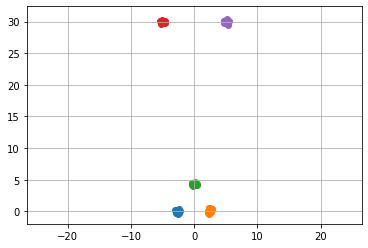

Preprocessing done...


Iteration 10: error is 9.649491
Iteration 20: error is 8.181151
Iteration 30: error is 7.431190
Iteration 40: error is 7.076877
Iteration 50: error is 6.883774
Iteration 60: error is 6.764324
Iteration 70: error is 6.683590
Iteration 80: error is 6.625462
Iteration 90: error is 6.581626
Iteration 100: error is 6.547403
Iteration 110: error is 0.184642
Iteration 120: error is 0.150766
Iteration 130: error is 0.132107
Iteration 140: error is 0.119705
Iteration 150: error is 0.110608
Iteration 160: error is 0.103529
Iteration 170: error is 0.097799
Iteration 180: error is 0.093030
Iteration 190: error is 0.088976
Iteration 200: error is 0.085473
Iteration 210: error is 0.082405
Iteration 220: error is 0.079689
Iteration 230: error is 0.077262
Iteration 240: error is 0.075077
Iteration 250: error is 0.073095
Iteration 260: error is 0.071287
Iteration 270: error is 0.069630
Iteration 280: error is 0.068102
Iteration 290: error is 0.066688
Iteration 300: error is 0.06

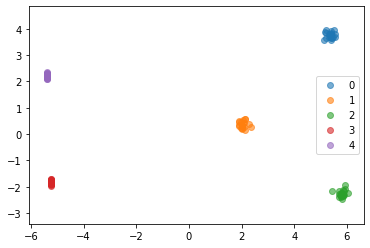

In [8]:

### TSNE

import math
import numpy as np
import pandas as pd
from sklearn import datasets, decomposition, metrics
from matplotlib import pyplot as plt
from hierarchy import dist, merge, calc_partitions, calc_dists
import copy

############# CONSTANTS ##############

DATA_SIZE = 100
ITERATIONS = 1000

######################################


############## METHODS ###############

def perplex_helper(Di, sigma):
    Pi = np.exp(-1*Di.copy() * sigma)
    Psum = np.sum(Pi)
    perp_calc = np.log(Psum) + sigma * np.sum(Di * Pi) / Psum
    Pf = Pi/Psum
    return Pf, perp_calc


def calc_p_vals(X, tol = 1e-5, perplexity = 30.0):
    (n, d) = X.shape

    partitions, pdist = calc_partitions(X, dist)
    pdists = pdist[0]

    P = np.zeros((n,n))
    sigmas = np.ones((n,1))


    for i in range(n):
        Di = pdists[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        Pf, perp_calc = perplex_helper(Di, sigmas[i])
        #perplexity calculation - binary search for best param
        min_ = -np.inf
        max_ = np.inf
        count = 0
        diff = perp_calc - np.log(perplexity)
        while diff > tol and count < 50:
            if diff > 0:
                min_ = sigmas[i].copy()
                if max_ == np.inf or max_ == -np.inf:
                    sigmas[i] = sigmas[i] * 2.
                else:
                    sigmas[i] = (sigmas[i] + max_) / 2.
            else:
                max_ = sigmas[i].copy()
                if min_ == np.inf or min_ == -np.inf:
                    sigmas[i] = sigmas[i] / 2.
                else:
                    sigmas[i] = (sigmas[i] + min_) / 2.
            count+=1
            Pf, perp_calc = perplex_helper(Di, sigmas[i])
            diff = perp_calc - np.log(perplexity)

        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = Pf
    return P

######################################################

###################### MAIN #########################

if __name__ == '__main__':

    desired_classes = [0,1,2,3,4]
    random_state = 1000
#     df = pd.read_csv('../mnist_784_zip/data/mnist_784_csv.csv')
#     df = df.loc[df['class'].isin(desired_classes)]
#     df = df.sample(n=DATA_SIZE, random_state=random_state)
#     labels = np.array(df['class'])
#     x_init = np.mat(df.drop('class', axis=1))
    np.random.seed(random_state)
    
    x_init, labels = make_5_asymmetric_blobs(5,10,30, .2 ,100, 100)


    # desired_classes = [0,1,2,3,4]
    # x_init, labels = datasets.make_blobs(n_samples=DATA_SIZE,n_features=100, centers=5, cluster_std = 1)
    y = np.random.rand(DATA_SIZE, 2)



    #PCA and normalize into ball of radius 1
    x = decomposition.PCA(n_components=30).fit_transform(x_init)
    x = x/np.var(np.linalg.norm(x, axis=1))

    (n,d) = x.shape

    pvals  = calc_p_vals(x)

    pvals = pvals + pvals.T       # calculate symmetric pvals
    pvals = pvals / np.sum(pvals)

    #early exaggeration
    pvals = pvals * 4.
    pvals = np.maximum(pvals, 1e-12)

    #gradient descent params
    dy = np.zeros((n,2))
    lr = 50

    # params for van der maaten's momentum magic!
    prev_y = np.zeros((n,2))
    init_momentum = 0.5
    st_momentum = 0.8
    gains = np.ones((n, 2))
    min_gain = 0.01
    eta = 500

    print('Preprocessing done...\n\n')
    for iter in range(ITERATIONS):


        #qvals for first layer -> computation trick from van der maaten's code
        sum_Y = np.sum(np.square(y), 1)
        num = -2. * np.dot(y, y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        qvals = num / np.sum(num)
        qvals = np.maximum(qvals, 1e-12)

        #compute gradient -> computation trick again stolen from van der maaten
        PQ = pvals - qvals
        for i in range(n):
            dy[i,:] = np.sum(np.tile(PQ[:, i] * num[:, i], (2, 1)).T * (y[i, :] - y), 0)

        # van der maaten's momentum magic
        # if iter < 20:
        #     momentum = init_momentum
        # else:
        #     momentum = st_momentum
        # gains = (gains + 0.2) * ((dy > 0.) != (iy > 0.)) + \
        #         (gains * 0.8) * ((dy > 0.) == (iy > 0.))
        # gains[gains < min_gain] = min_gain
        # iy = momentum * iy - eta * (gains * dy)
        # y = y + iy
        # y = y - np.tile(np.mean(y, 0), (n, 1))

        #our shitty gd implementation
        y = y-lr*dy

        #print loss value
        if (iter + 1) % 10 == 0:
            L = np.sum(pvals * np.log(pvals / qvals))  #KL divergence
            print("Iteration %d: error is %f" % (iter + 1, L))

        #stop early exaggeration
        if iter == 100:
            pvals = pvals/4

    try:
#         np.save('tsne_data.csv', y)
#         np.save('tsne_labels.csv', labels)
        plt.figure()
        base = {}
        for class_ in desired_classes:
            base[class_] = []
        _dict = copy.deepcopy(base)
        for i,row in enumerate(y):
            _dict[labels[i]].append(row)
        for i in _dict.keys():
            plt.scatter(np.array(_dict[i])[:,0], np.array(_dict[i])[:,1], alpha=0.6)
        plt.legend(desired_classes)
    except Exception as e:
        print(e)
        plt.scatter(y[:,0], y[:,1], alpha=0.2)
    plt.axis('equal')
    plt.show()
#     plt.savefig('tsne_result_art_100_300.png')

#####################################################


/home/mstrals/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  
/home/mstrals/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  import sys


array([6.22974152e-01, 7.30105810e-02, 3.51755035e-02, 2.58703504e-01,
       3.98398385e-04, 4.03961155e-05, 1.85622210e-03, 6.11858152e-04,
       2.08441176e-04, 3.28054119e-04, 1.74877473e-04, 2.14916832e-04,
       1.22008497e-03, 4.55996237e-04, 7.01508952e-05, 3.52761236e-04,
       3.41134039e-05, 2.60532585e-04, 4.33507263e-05, 4.64243300e-04,
       2.27205041e-04, 8.38324254e-05, 2.48015791e-04, 4.08186056e-04,
       7.22374453e-05, 1.70693189e-04, 6.49913697e-05, 4.54896098e-05,
       4.54999073e-05, 6.00033747e-05, 6.64647526e-05, 4.54466219e-05,
       5.29244826e-05, 1.41416725e-05, 5.80071488e-06, 3.01518520e-04,
       1.30928296e-04, 2.36204651e-05, 1.56902953e-05, 1.10200244e-06,
       4.88410481e-05, 1.65760151e-06, 7.40337947e-05, 3.25037563e-05,
       5.97574427e-06, 1.17620915e-05, 2.13651595e-05, 3.80560123e-05,
       6.39113954e-05, 1.93337107e-05, 2.41430602e-06, 8.71755870e-05,
       3.18249619e-06, 4.76848557e-05, 1.07306653e-05, 7.28105224e-06,
      

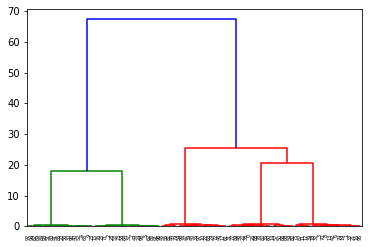

In [10]:
get_dendrogram_weights(y)